<a href="https://colab.research.google.com/github/lilymarzano/LMSpatialDataFrames/blob/master/Marzano_Lily_Lam178_Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 4: Neural Network Models

In [1]:
# Install all core packages for this tutorial
%pip install tensorflow keras_tuner

# (Optional) Upgrade TensorFlow to the latest version if needed
%pip install --upgrade --force-reinstall tensorflow

  Using cached tensorflow-2.20.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2010_x86_64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached protobuf-6.33.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached termcolor-3.2.0-py3-none-

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# Scikit-learn (Machine Learning Utilities)
# ============================================================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ============================================================
# TensorFlow / Keras (Deep Learning Framework)
# ============================================================
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, models
from tensorflow.keras.layers import Dense, Normalization, Dropout, BatchNormalization
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

# ============================================================
# Keras Tuner (Hyperparameter Optimization)
# ============================================================
import keras_tuner as kt

# ============================================================
# Spatial Tools (for Mapping and Visualization)
# ============================================================
import geopandas as gpd

# ============================================================
# Warning Control & Random Seed (for Reproducibility)
# ============================================================
from sklearn.exceptions import ConvergenceWarning

# Suppress non-critical warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Set random seeds for reproducibility
SEED = 42
tf.random.set_seed(SEED)

print(f"Libraries successfully loaded. Random seed set to {SEED}. TensorFlow version: {tf.__version__}")

Libraries successfully loaded. Random seed set to 42. TensorFlow version: 2.20.0


In [3]:
# Part 1. Regression for Soybean Yield (4 pts)Links to an external site.
# 1.1 Scikit-learn Neural Network Regression (MLPRegressor)

In [4]:
# Load dataset
df = pd.read_csv("US_corn.csv", dtype={"GEOID": str, "STATEFP": str})

# Quick checks
print("Data shape:", df.shape)
df.head()

Data shape: (4902, 15)


,GEOID,STATEFP,year,sm,precip,tmax,tmean,tmin,vpdmax,vpdmin,vpdmean,ln_farmfertN-kg-perha,ln_farmfertP-kg-perha,yield,ln_yield
0,05001,05,2012,0.275861,119.302588,32.662997,27.156237,21.650723,28.299053,2.831169,4.133908,6.208415,4.027820,188.6,5.239628
1,05121,05,2012,0.311416,58.997452,32.987670,26.151992,19.317486,31.379733,1.892903,4.265532,6.134469,3.953874,164.6,5.103518
2,05095,05,2012,0.258084,71.780403,32.810035,27.106981,21.405143,29.025942,2.902081,4.262291,5.715254,3.534659,177.4,5.178407
3,05067,05,2012,0.311580,46.836466,33.144187,27.018299,20.893662,30.092962,2.450584,4.322683,6.626927,4.446331,166.9,5.117395
4,05021,05,2012,0.270177,52.206763,32.938680,26.581765,20.226125,30.262684,2.338240,4.305436,6.009839,3.829244,182.7,5.207845


In [5]:
# Define feature set and target variable
features = [
    'STATEFP',
    'sm',
    'precip',
    'tmean',
    'vpdmean'
]

# Select features (X) and target (y)
X = df[features]
y = df["ln_yield"]

# Encode categorical variables
X = pd.get_dummies(X, columns=['STATEFP'])

# Quick data quality checks
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Any NA in X:", X.isna().any().any())
print("Any NA in y:", y.isna().any())

# If NA found in y, drop corresponding rows and then rerun X and y selection
# df = df.dropna(subset=['ln_yield'])


X shape: (4902, 16)
y shape: (4902,)
Any NA in X: False
Any NA in y: False


In [6]:
# Split data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Display the resulting dataset shapes
print("Training set shape:", X_train.shape)
print("Testing set shape: ", X_test.shape)

Training set shape: (3431, 16)
Testing set shape:  (1471, 16)


In [7]:
# Build a pipeline: scaling + simple MLP (1 hidden layer with 10 neurons)
nn_base = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(10,),  # one hidden layer with 10 neurons
        random_state=42,
        max_iter=1000              # increase if you see convergence warnings
    ))
])

# Fit the baseline model
nn_base.fit(X_train, y_train)

# Predict on the test set
y_pred = nn_base.predict(X_test)

# Evaluate model performance
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred)) # Calculate RMSE by taking the square root of MSE
r2_base = r2_score(y_test, y_pred)

print("Baseline Evaluation:")
print(f"RMSE: {rmse_base:.4f}")
print(f"R²  : {r2_base:.4f}")

Baseline Evaluation:
RMSE: 0.2053
R²  : 0.6445


In [8]:
param_dist = {
    "mlp__hidden_layer_sizes": [(32,), (64,), (64, 32), (128, 64, 32)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [1e-4, 1e-3, 1e-2],        # L2 regularization strength
    "mlp__learning_rate_init": [1e-3, 1e-4],
    "mlp__early_stopping": [True],
    "mlp__validation_fraction": [0.1],
}

In [9]:
# Initialize randomized search
random_search = RandomizedSearchCV(
    estimator=nn_base,                   # pipeline defined earlier
    param_distributions=param_dist,
    n_iter=5,                           # number of random combinations to try
    scoring="neg_mean_squared_error",    # optimize for RMSE
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Run search on training data
random_search.fit(X_train, y_train)

# Print results
best_params = random_search.best_params_
best_cv_rmse = np.sqrt(-random_search.best_score_)

print("Best Parameters:", best_params)
print(f"Best Cross-Validation RMSE: {best_cv_rmse:.4f}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'mlp__validation_fraction': 0.1, 'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (64,), 'mlp__early_stopping': True, 'mlp__alpha': 0.0001, 'mlp__activation': 'tanh'}
Best Cross-Validation RMSE: 0.1861


In [10]:
# Get best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Predictions on the test set
y_pred_tuned = best_model.predict(X_test)

# Evaluate tuned model
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned)) # Calculate RMSE by taking the square root of MSE
r2_tuned = r2_score(y_test, y_pred_tuned)

# Compare with baseline model (make sure you ran Section 4 first)
print(" Model Comparison (Test Set)")
print(f"Baseline NN → RMSE: {rmse_base:.4f},  R²: {r2_base:.4f}")
print(f"Tuned NN    → RMSE: {rmse_tuned:.4f},  R²: {r2_tuned:.4f}")

 Model Comparison (Test Set)
Baseline NN → RMSE: 0.2053,  R²: 0.6445
Tuned NN    → RMSE: 0.1850,  R²: 0.7115


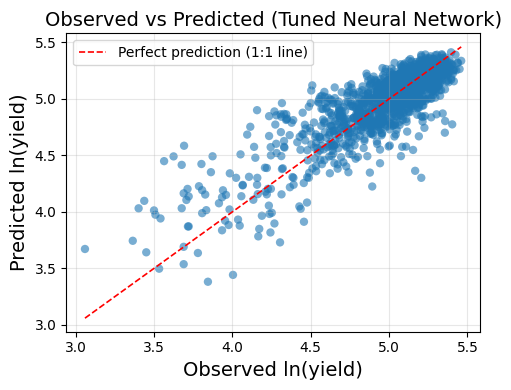

In [11]:
plt.figure(figsize=(5,4))
plt.scatter(y_test, y_pred_tuned, alpha=0.6, edgecolor='none')
lims = [min(y_test.min(), y_pred_tuned.min()), max(y_test.max(), y_pred_tuned.max())]
plt.plot(lims, lims, 'r--', linewidth=1.2, label="Perfect prediction (1:1 line)")
plt.xlabel("Observed ln(yield)", fontsize = 14)
plt.ylabel("Predicted ln(yield)", fontsize = 14)
plt.title("Observed vs Predicted (Tuned Neural Network)", fontsize = 14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


The best parameters for neural network regression are a validation fraction of .1, an initial learning rate of .001, 64 hidden layers, including early stopping, an alpha value of .0001, and a hyperbolic tangent function as the activation. The cross-validation RMSE is 0.1861. The R squared is  .7115.

The tuned model performes much better than the baseline model. The RMSE went down from .2350 to .1850, meaning that prediction error decreased. Additionally, the R squared value increased from the baseline .6445 to .7115. These results suggest that hyperparameter tuning improved the model.

1.2 TensorFlow/Keras Neural Network Regression (KerasTuner)

In [12]:
# 1. Normalize input features (fit on training data only)
normalizer = Normalization()
normalizer.adapt(X_train.values)  # learns mean & variance from training features

# 2. Define a simple Sequential model
model = Sequential([
    normalizer,                           # normalization layer
    Dense(units=25, activation='relu'),   # hidden layer (25 neurons, ReLU activation)
    Dense(units=15, activation='sigmoid'),# second hidden layer (15 neurons, Sigmoid activation)
    Dense(units=1, activation='linear')   # output layer for regression
])

# 3. Compile the model
model.compile(
    optimizer='adam',                     # adaptive learning rate optimizer
    loss='mse',                           # mean squared error loss
    metrics=[RootMeanSquaredError()]      # RMSE for interpretability
)

# 4. Train the baseline model
history = model.fit(
    X_train, y_train,
    epochs=100,
    verbose=1                             # display training progress
)

# 5. Predict on the test set
y_pred = model.predict(X_test)

# 6. Evaluate baseline performance
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred)) # Calculate RMSE by taking the square root of MSE
r2_base = r2_score(y_test, y_pred)

print("\nBaseline Neural Network Evaluation")
print(f"RMSE: {rmse_base:.4f}")
print(f"R²  : {r2_base:.4f}")

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.7498 - root_mean_squared_error: 2.9580 
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4354 - root_mean_squared_error: 1.1981
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1385 - root_mean_squared_error: 0.3722
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0743 - root_mean_squared_error: 0.2726
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0654 - root_mean_squared_error: 0.2558
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0608 - root_mean_squared_error: 0.2465
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0576 - root_mean_squared_error: 0.2399
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0552 - root_mean_squared_error: 0.2348
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0531 - root_mean_squared_error: 0.2305
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0514 - root_mean_

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 16)             │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           425 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │           390 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,528 (9.88 KB)

 Trainable params: 831 (3.25 KB)

 Non-trainable params: 33 (136.00 B)

 Optimizer params: 1,664 (6.50 KB)

In [14]:
# 1. Define the EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss',          # metric to monitor
    patience=5,                  # epochs to wait before stopping
    restore_best_weights=True,   # revert to best model weights
    verbose=1                    # print when training stops early
)

# 2. Train the model with a validation split
history = model.fit(
    X_train, y_train,
    validation_split=0.2,        # 20% of training data used for validation
    epochs=100,                  # high limit; EarlyStopping will stop earlier
    batch_size=32,
    callbacks=[earlystop],
    verbose=1
)

# 3. Predict on test data
y_pred = model.predict(X_test)

# 4. Evaluate model performance
rmse_earlystop = np.sqrt(mean_squared_error(y_test, y_pred))
r2_earlystop = r2_score(y_test, y_pred)


# 5. Compare with baseline model without early stopping
print("\n Model Performance on Test Set (with Early Stopping):")
print(f"RMSE : {rmse_earlystop:.4f}")
print(f"R²   : {r2_earlystop:.4f}")

print("\n Comparison with Baseline Model:")
print(f"Baseline RMSE : {rmse_base:.4f}")
print(f"Baseline R²   : {r2_base:.4f}")

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0258 - root_mean_squared_error: 0.1607 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1693
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0257 - root_mean_squared_error: 0.1604 - val_loss: 0.0289 - val_root_mean_squared_error: 0.1700
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0257 - root_mean_squared_error: 0.1602 - val_loss: 0.0291 - val_root_mean_squared_error: 0.1706
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0256 - root_mean_squared_error: 0.1600 - val_loss: 0.0292 - val_root_mean_squared_error: 0.1709
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255 - root_mean_squared_error: 0.1598 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1711
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255 - root_mean_squared_error: 0.1596 - val_loss: 0.0294 - val_root_mean_squared_error: 0.1713
Epoch 6: early stopping
Restoring model weights from the e

In [15]:
# The 'normalizer' has already been adapted on X_train
def build_model(hp):
    """
    KerasTuner-compatible model builder using the Sequential API.
    Each hidden layer can have its own 'units' and 'activation'.
    """
    model = keras.Sequential(name="regression_model")

    # Input normalization (use pre-adapted normalizer)
    model.add(normalizer)

    # ===== Layer 1 hyperparameters =====
    units_1 = hp.Int("units_1", min_value=16, max_value=128, step=16)
    activation_1 = hp.Choice("activation_1", ["relu", "tanh", "sigmoid"])

    # ===== Layer 2 hyperparameters (independent) =====
    units_2 = hp.Int("units_2", min_value=8, max_value=128, step=8)
    activation_2 = hp.Choice("activation_2", ["relu", "tanh", "sigmoid"])

    # Hidden layers (apply each to the previous tensor using Sequential.add)
    model.add(layers.Dense(units_1, activation=activation_1, name="hidden_1"))
    model.add(layers.Dense(units_2, activation=activation_2, name="hidden_2"))

    # Output layer for regression (single numeric value)
    model.add(layers.Dense(1, activation="linear", name="output"))

    # Tunable learning rate for Adam optimizer
    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[RootMeanSquaredError(name="rmse")]
    )

    return model


In [16]:
# ============================================================
# STEP 1 — Initialize the Random Search Tuner
# ============================================================

# KerasTuner RandomSearch explores random combinations of hyperparameters
# to identify the model configuration that minimizes validation RMSE.
tuner = kt.RandomSearch(
    build_model,                               # model-building function
    objective=kt.Objective('val_rmse', 'min'), # metric to minimize (validation RMSE)
    max_trials=5,                              # number of random hyperparameter combinations to test
    seed=42,                                   # ensures reproducibility
    directory='kt_rand',                       # directory to store tuner results
    project_name='crop_yield'                  # subfolder name for this tuning experiment
)

# ============================================================
# STEP 2 — Define EarlyStopping Callback
# ============================================================

# EarlyStopping halts training automatically if validation RMSE stops improving,
# which prevents overfitting and reduces computation time.
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_rmse',        # metric to monitor
    patience=5,                # stop after 5 epochs of no improvement
    mode='min',                # minimize RMSE
    restore_best_weights=True  # revert to the model weights with best validation RMSE
)

# ============================================================
# STEP 3 — Run the Random Search Tuning Process
# ============================================================

# The tuner trains multiple models, each with a unique combination of hyperparameters.
# Each trial uses a validation split to evaluate performance and rank results.
tuner.search(
    X_train, y_train,
    epochs=100,                 # maximum epochs per trial; EarlyStopping typically halts earlier
    validation_split=0.2,       # use 20% of training data for validation
    callbacks=[early_stop],     # apply EarlyStopping during training
    verbose=2                   # print progress for each trial
)

# ============================================================
# STEP 4 — Retrieve the Best Hyperparameter Combination
# ============================================================

# Once tuning completes, extract the best hyperparameters based on validation RMSE.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the optimal hyperparameter configuration
print("Best hyperparameters:", best_hps.values)


Trial 5 Complete [00h 00m 19s]
val_rmse: 0.17777657508850098

Best val_rmse So Far: 0.17777657508850098
Total elapsed time: 00h 09m 12s
Best hyperparameters: {'units_1': 128, 'activation_1': 'tanh', 'units_2': 64, 'activation_2': 'tanh', 'learning_rate': 0.01}


In [17]:
# ============================================================
# STEP 1 — Build the Best Model from Tuned Hyperparameters
# ============================================================
best_model = tuner.hypermodel.build(best_hps)

# ============================================================
# STEP 2 — Train the Model with Consistent Settings
# ============================================================
history = best_model.fit(
    X_train, y_train,
    epochs=100,                 # upper limit; EarlyStopping will likely stop earlier
    validation_split=0.2,       # consistent with tuning
    callbacks=[early_stop],     # reuse EarlyStopping for stable training
    verbose=2
)

# ============================================================
# STEP 3 — Evaluate Model Performance on Test Set
# ============================================================
y_pred_tuned_tf = best_model.predict(X_test).ravel()  # flatten predictions for metrics

rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_tuned_tf))
r2_best   = r2_score(y_test, y_pred_tuned_tf)

print("\nModel Performance on Test Set (with hyperparameter tuning):")
print(f"RMSE : {rmse_best:.4f}")
print(f"R²   : {r2_best:.4f}")

Epoch 1/100
86/86 - 3s - 37ms/step - loss: 2.6519 - rmse: 1.6285 - val_loss: 0.0500 - val_rmse: 0.2236
Epoch 2/100
86/86 - 0s - 4ms/step - loss: 0.0501 - rmse: 0.2239 - val_loss: 0.0457 - val_rmse: 0.2137
Epoch 3/100
86/86 - 0s - 4ms/step - loss: 0.0480 - rmse: 0.2190 - val_loss: 0.0438 - val_rmse: 0.2092
Epoch 4/100
86/86 - 1s - 7ms/step - loss: 0.0463 - rmse: 0.2152 - val_loss: 0.0416 - val_rmse: 0.2039
Epoch 5/100
86/86 - 1s - 7ms/step - loss: 0.0453 - rmse: 0.2129 - val_loss: 0.0402 - val_rmse: 0.2005
Epoch 6/100
86/86 - 1s - 7ms/step - loss: 0.0444 - rmse: 0.2108 - val_loss: 0.0387 - val_rmse: 0.1968
Epoch 7/100
86/86 - 1s - 6ms/step - loss: 0.0433 - rmse: 0.2080 - val_loss: 0.0370 - val_rmse: 0.1923
Epoch 8/100
86/86 - 0s - 6ms/step - loss: 0.0418 - rmse: 0.2044 - val_loss: 0.0358 - val_rmse: 0.1892
Epoch 9/100
86/86 - 0s - 4ms/step - loss: 0.0404 - rmse: 0.2011 - val_loss: 0.0352 - val_rmse: 0.1876
Epoch 10/100
86/86 - 0s - 4ms/step - loss: 0.0394 - rmse: 0.1985 - val_loss: 0.03

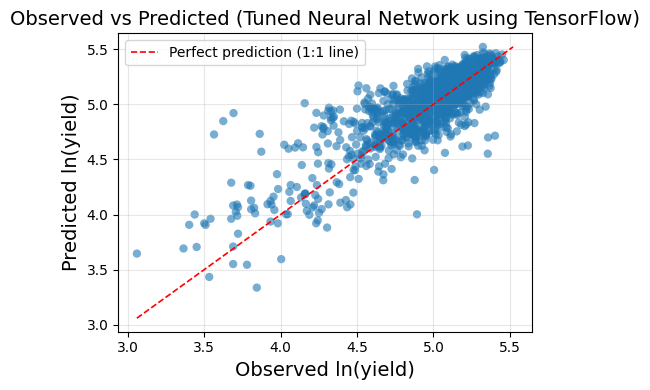

In [18]:
# Visualize Observed vs Predicted
plt.figure(figsize=(5,4))
plt.scatter(y_test, y_pred_tuned_tf, alpha=0.6, edgecolor='none')
lims = [min(y_test.min(), y_pred_tuned_tf.min()), max(y_test.max(), y_pred_tuned_tf.max())]
plt.plot(lims, lims, 'r--', linewidth=1.2, label="Perfect prediction (1:1 line)")
plt.xlabel("Observed ln(yield)", fontsize=14)
plt.ylabel("Predicted ln(yield)", fontsize=14)
plt.title("Observed vs Predicted (Tuned Neural Network using TensorFlow)", fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [19]:
# --- Compute county-level mean climate features (2012–2017 average) ---
features_withoutSTATEFP = ["sm", "precip", "tmean", "vpdmean"]

county_means = (
    df.groupby(["GEOID", "STATEFP"])[features_withoutSTATEFP]
      .mean()
      .reset_index()
)

# --- Prepare model input features ---
X_county_means = county_means[features]

# One-hot encode STATEFP for model compatibility
X_county_means = pd.get_dummies(X_county_means, columns=["STATEFP"])

# --- Predict county-level yields ---
county_means["pred_ln_yield"] = best_model.predict(X_county_means)
county_means["pred_yield"] = np.exp(county_means["pred_ln_yield"])  # back-transform

county_means.head()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,GEOID,STATEFP,sm,precip,tmean,vpdmean,pred_ln_yield,pred_yield
0,05001,05,0.323529,104.051802,26.779844,3.210161,5.281720,196.707947
1,05003,05,0.284113,119.268197,26.853813,3.178624,5.307857,201.916946
2,05017,05,0.288556,124.194501,27.093338,3.150882,5.304886,201.318008
3,05021,05,0.330210,101.700437,25.897556,2.979700,5.272318,194.867111
4,05029,05,0.319360,61.575923,27.837163,5.599119,4.796185,121.047806


In [20]:
# --- Create +1°C scenario ---
X_county_plus1C = X_county_means.copy()
X_county_plus1C["tmean"] = X_county_plus1C["tmean"] + 1  # add +1°C to mean temperature

# --- Predict yields under the +1°C scenario ---
county_means["pred_ln_yield_plus1C"] = best_model.predict(X_county_plus1C)
county_means["pred_yield_plus1C"] = np.exp(county_means["pred_ln_yield_plus1C"])  # back-transform to yield units

# --- Compute yield differences (absolute and percentage) ---
county_means["pred_yield_plus1C_dif"] = (
    county_means["pred_yield_plus1C"] - county_means["pred_yield"]
)
county_means["pred_yield_plus1C_dif_percent"] = (
    county_means["pred_yield_plus1C_dif"] / county_means["pred_yield"] * 100
)

# Preview results
county_means.head()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,GEOID,STATEFP,sm,precip,tmean,vpdmean,pred_ln_yield,pred_yield,pred_ln_yield_plus1C,pred_yield_plus1C,pred_yield_plus1C_dif,pred_yield_plus1C_dif_percent
0,05001,05,0.323529,104.051802,26.779844,3.210161,5.281720,196.707947,5.250425,190.647339,-6.060608,-3.081018
1,05003,05,0.284113,119.268197,26.853813,3.178624,5.307857,201.916946,5.286322,197.615189,-4.301758,-2.130459
2,05017,05,0.288556,124.194501,27.093338,3.150882,5.304886,201.318008,5.271813,194.768829,-6.549179,-3.253151
3,05021,05,0.330210,101.700437,25.897556,2.979700,5.272318,194.867111,5.276450,195.674026,0.806915,0.414085
4,05029,05,0.319360,61.575923,27.837163,5.599119,4.796185,121.047806,4.842613,126.800217,5.752411,4.752181


In [24]:
# --- Filepaths ---
url_counties = "tl_2023_us_county.shp"
url_states = "tl_2023_us_state.shp"

# --- Unzip shapefiles if necessary (assuming they are in .zip archives) ---
import zipfile
import os

# Function to unzip files
def unzip_if_needed(zip_path, extract_path="."):
    if os.path.exists(zip_path) and zip_path.endswith(".zip"):
        # Always extract if the zip file exists, to ensure all components are present and fresh
        print(f"Extracting {zip_path} to {extract_path}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Extraction of {zip_path} complete.")
    else:
        print(f"Zip file {zip_path} not found or not a zip file. Assuming shapefile components are already available.")

# Download zip files if not present
if not os.path.exists("tl_2023_us_county.zip"):
    print("Downloading tl_2023_us_county.zip...")
    !wget -q https://www2.census.gov/geo/tiger/TIGER2023/COUNTY/tl_2023_us_county.zip
    print("Download complete.")

if not os.path.exists("tl_2023_us_state.zip"):
    print("Downloading tl_2023_us_state.zip...")
    !wget -q https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip
    print("Download complete.")

unzip_if_needed("tl_2023_us_county.zip")
unzip_if_needed("tl_2023_us_state.zip")


# --- Read shapefiles ---
counties = gpd.read_file(url_counties)
states = gpd.read_file(url_states)

# --- Align CRS ---
states = states.to_crs(counties.crs)

# --- Merge yield data with county geometries ---
counties_merged = counties.merge(county_means, on=["GEOID", "STATEFP"])

# --- Keep only states that have data ---
state_fips_with_data = counties_merged["STATEFP"].unique()
states_with_data = states[states["STATEFP"].isin(state_fips_with_data)]

Download complete.
Download complete.
Extracting tl_2023_us_county.zip to ....
Extraction of tl_2023_us_county.zip complete.
Extracting tl_2023_us_state.zip to ....
Extraction of tl_2023_us_state.zip complete.


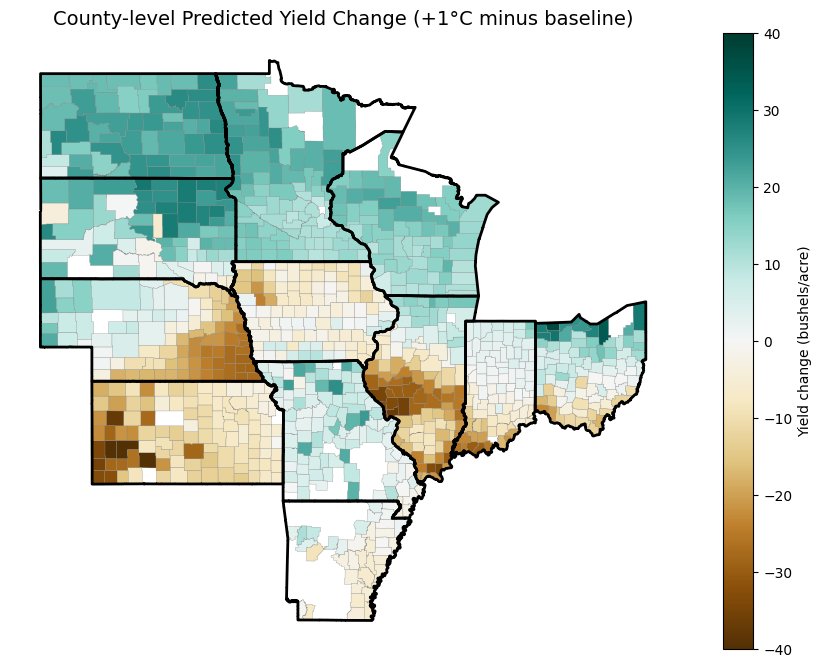

In [25]:
# Yield Difference Map (+1°C – Baseline)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

counties_merged.plot(
    column="pred_yield_plus1C_dif",
    cmap="BrBG",
    linewidth=0.2,
    ax=ax,
    edgecolor="grey",
    legend=True,
    legend_kwds={'label': "Yield change (bushels/acre)"},
    vmin = -40,
    vmax = 40,
)

# overlay state borders with thicker lines
states_with_data.boundary.plot(ax=ax, color="black", linewidth=2)

ax.set_title("County-level Predicted Yield Change (+1°C minus baseline)", fontsize=14)
ax.axis("off")
plt.savefig("yield_change_map.png", dpi=300, bbox_inches="tight")
plt.show()

The RMSE and R squared for the Keras tuned model are 2.7118 and -63.7829, respectively. The negative R squared value indicates that the model is not learning the patterns in the data correctly. The high RMSE also indicates this. The Observed vs Predicted also confirms this. There is a large spread of prediction around the 1:1 line.


In this example, the tuning process did not improve the baseline model and in fact made the model perform worse. To curb underfitting, you can make the model more complex via more layers, using more features, or lowering the alpha value to prevent too much regularization. To curb overfitting, you can use fewer layers, use more data, or stop the model early.

With this model, most of the negative crop yield is confined to the most Southern states. In the more Northern states, there is no areas of negative yield chage. There is broad spatial differences, but not inter-region variation. Compared to this model, the tree ensemble spatial variation is much more significant. In the tree ensemble model, there are areas of negative crop yield within the more Northern states. Additionally, there are "darker" areas of increased crop yield areas in the more Northern states.

In [ ]:
# Part 2: Classification for Handwritten Images (Fashion MNIST)

In [26]:
# Load MNIST dataset from TensorFlow
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Inspect dataset structure
print("Training images shape:", X_train.shape, "labels shape:", y_train.shape)
print("Test images shape:    ", X_test.shape,  "labels shape:", y_test.shape)
print("Pixel value range: min =", X_train.min(), "max =", X_train.max())
print("Unique class labels:", np.unique(y_train))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training images shape: (60000, 28, 28) labels shape: (60000,)
Test images shape:     (10000, 28, 28) labels shape: (10000,)
Pixel value range: min = 0 max = 255
Unique class labels: [0 1 2 3 4 5 6 7 8 9]


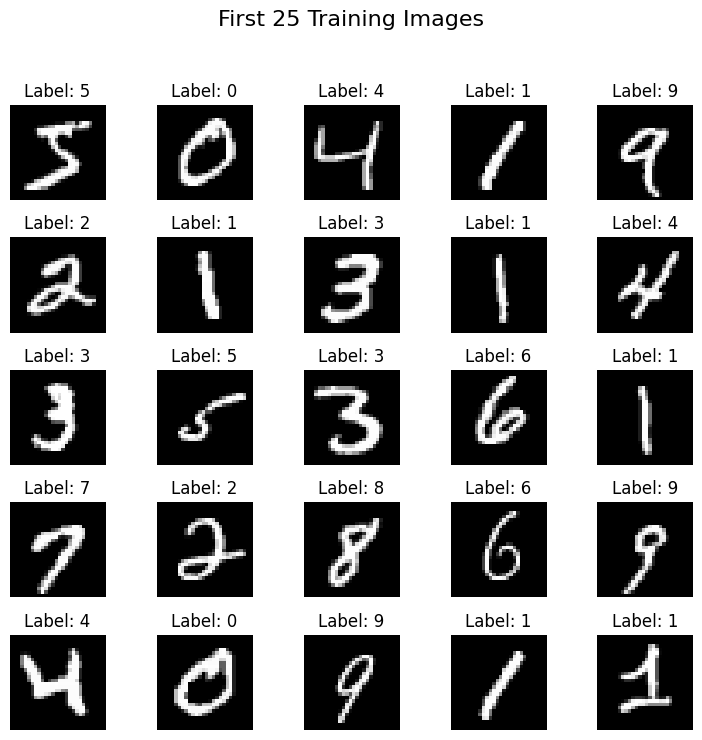

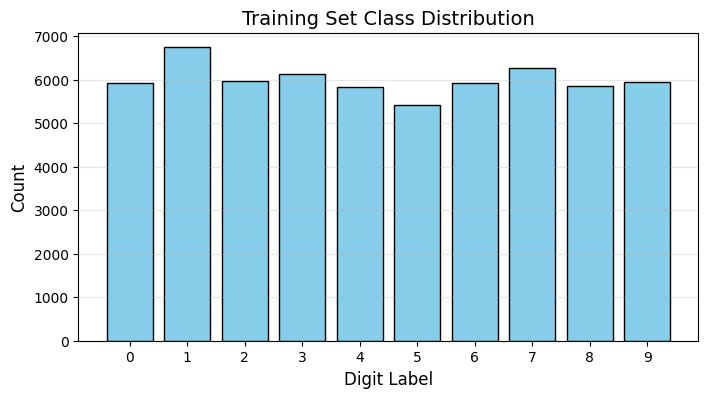

In [27]:
# Function to visualize a grid of sample images with labels
def show_samples(images, labels, n_rows=5, n_cols=5, title="MNIST samples"):
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    plt.suptitle(title, fontsize=16)
    for i in range(n_rows * n_cols):
        ax = plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.title(f"Label: {labels[i]}")
        plt.axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Display 25 example training images
show_samples(X_train, y_train, n_rows=5, n_cols=5, title="First 25 Training Images")

# Visualize the number of samples per digit class
plt.figure(figsize=(8, 4))
plt.hist(y_train, bins=np.arange(11) - 0.5, rwidth=0.8, color="skyblue", edgecolor="black")
plt.xticks(range(10))
plt.xlabel("Digit Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Training Set Class Distribution", fontsize=14)
plt.grid(axis="y", alpha=0.3)
plt.show()

In [28]:
# ============================================================
# STEP 1 — Preprocess for Dense Neural Network
# - Flatten 28x28 images → 784-d vectors
# - Normalize pixel values from [0,255] to [0,1]
# ============================================================
X_train_flat = X_train.reshape((-1, 28 * 28)).astype("float32") / 255.0
X_test_flat  = X_test.reshape((-1, 28 * 28)).astype("float32") / 255.0

print("After flattening: X_train_flat shape =", X_train_flat.shape)


# ============================================================
# STEP 2 — Build a Simple Dense (Fully Connected) Model
# ============================================================
model = models.Sequential([
    layers.Dense(16, activation='relu', input_shape=(784,)),  # hidden layer
    layers.Dense(10, activation='softmax')                    # output layer (10 digits)
])


# ============================================================
# STEP 3 — Compile the Model
# ============================================================
model.compile(
    optimizer='adam',                             # adaptive optimizer
    loss='sparse_categorical_crossentropy',       # suitable for integer labels
    metrics=['accuracy']                          # track classification accuracy
)

# Display architecture summary
model.summary()


# ============================================================
# STEP 4 — Train the Model (with EarlyStopping)
# ============================================================
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',          # monitor validation loss
    patience=3,                  # stop if no improvement after 3 epochs
    restore_best_weights=True,   # revert to best weights
    verbose=1
)

history = model.fit(
    X_train_flat, y_train,
    epochs=50,                   # generous limit; EarlyStopping will stop earlier
    batch_size=32,               # process 32 samples per update
    validation_split=0.1,        # hold out 10% of training data for validation
    callbacks=[early_stop],      # enable early stopping
    verbose=2
)


# ============================================================
# STEP 5 — Evaluate Model Performance on the Test Set
# ============================================================
test_loss, test_acc = model.evaluate(X_test_flat, y_test, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f}")

After flattening: X_train_flat shape = (60000, 784)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │        12,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,730 (49.73 KB)

 Trainable params: 12,730 (49.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1688/1688 - 5s - 3ms/step - accuracy: 0.8735 - loss: 0.4522 - val_accuracy: 0.9370 - val_loss: 0.2223
Epoch 2/50
1688/1688 - 6s - 3ms/step - accuracy: 0.9297 - loss: 0.2451 - val_accuracy: 0.9485 - val_loss: 0.1846
Epoch 3/50
1688/1688 - 6s - 4ms/step - accuracy: 0.9397 - loss: 0.2104 - val_accuracy: 0.9530 - val_loss: 0.1712
Epoch 4/50
1688/1688 - 6s - 3ms/step - accuracy: 0.9446 - loss: 0.1915 - val_accuracy: 0.9537 - val_loss: 0.1642
Epoch 5/50
1688/1688 - 4s - 2ms/step - accuracy: 0.9487 - loss: 0.1782 - val_accuracy: 0.9558 - val_loss: 0.1601
Epoch 6/50
1688/1688 - 10s - 6ms/step - accuracy: 0.9513 - loss: 0.1679 - val_accuracy: 0.9567 - val_loss: 0.1575
Epoch 7/50
1688/1688 - 4s - 3ms/step - accuracy: 0.9540 - loss: 0.1593 - val_accuracy: 0.9568 - val_loss: 0.1560
Epoch 8/50
1688/1688 - 9s - 5ms/step - accuracy: 0.9559 - loss: 0.1520 - val_accuracy: 0.9563 - val_loss: 0.1551
Epoch 9/50
1688/1688 - 6s - 3ms/step - accuracy: 0.9579 - loss: 0.1462 - val_accuracy: 0.9572 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


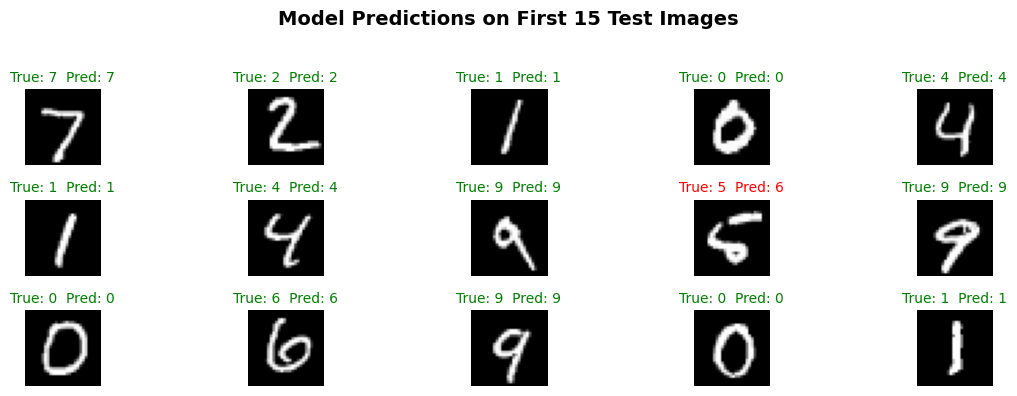

In [29]:
# ============================================================
# STEP 6 — Visualize Predictions (first 15 test samples)
# - Green title = correct prediction; Red = incorrect
# ============================================================

# Generate predicted class probabilities for the first 15 test samples
pred_probs = model.predict(X_test_flat[:15])

# Convert probabilities (10 per sample) to the most likely class label (0–9)
pred_labels = np.argmax(pred_probs, axis=1)

# Create a visualization grid for comparison
plt.figure(figsize=(12, 4))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[i], cmap="gray")

    # Color code predictions: green = correct, red = incorrect
    color = "green" if pred_labels[i] == y_test[i] else "red"
    plt.title(f"True: {y_test[i]}  Pred: {pred_labels[i]}", color=color, fontsize=10)
    plt.axis("off")

# Add a descriptive title for the figure
plt.suptitle("Model Predictions on First 15 Test Images", fontsize=14, weight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [30]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(784,)))  # input layer for flattened 28x28 images

    # Tune number of hidden layers (1–3)
    n_layers = hp.Int('n_layers', min_value=1, max_value=3)
    for i in range(n_layers):
        # Tune number of units and activation function for each layer
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        activation = hp.Choice(f'activation_{i}', ['relu', 'tanh', 'elu'])
        model.add(layers.Dense(units, activation=activation))

    # Output layer (10 neurons for 10 digit classes)
    model.add(layers.Dense(10, activation='softmax'))

    # Tunable learning rate for Adam optimizer
    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [31]:
# ============================================================
# Initialize the Random Search Tuner
# ============================================================
tuner = kt.RandomSearch(
    build_model,                     # model-building function
    objective='val_accuracy',        # maximize validation accuracy
    max_trials=5,                    # number of random combinations to test
    executions_per_trial=1,          # train each configuration once
    directory='kt_random_class',     # folder to store tuner results
    project_name='mnist_class', # project name for this tuning task
    seed=42                          # random seed for reproducibility
)

In [32]:
# ============================================================
# Run the Tuner Search
# ============================================================

# Define EarlyStopping to prevent overfitting during tuning
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',       # metric to monitor
    patience=5,                   # stop if no improvement after 5 epochs
    mode='max',                   # maximize validation accuracy
    restore_best_weights=True     # restore best weights after stopping
)

# Execute hyperparameter search
tuner.search(
    X_train_flat, y_train,
    epochs=20,                    # upper limit; EarlyStopping may stop sooner
    validation_split=0.2,         # reserve 20% for validation
    callbacks=[early_stop],       # apply early stopping
    verbose=2                     # print detailed tuning progress
)


Trial 5 Complete [00h 01m 13s]
val_accuracy: 0.9284999966621399

Best val_accuracy So Far: 0.9772499799728394
Total elapsed time: 00h 10m 30s


In [33]:
# ============================================================
# Retrieve and Train the Best Model
# ============================================================

# Retrieve the best hyperparameters from the tuning search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest hyperparameters found:")
for k, v in best_hps.values.items():
    print(f"  {k}: {v}")

# Rebuild the model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Retrain the best model with EarlyStopping for stability
history = best_model.fit(
    X_train_flat, y_train,
    epochs=30,                     # higher limit; EarlyStopping will halt early if needed
    validation_split=0.2,          # 20% of training data used for validation
    callbacks=[early_stop],        # stop when validation accuracy stops improving
    verbose=2
)


Best hyperparameters found:
  n_layers: 1
  units_0: 128
  activation_0: elu
  learning_rate: 0.001
  units_1: 128
  activation_1: tanh
  units_2: 32
  activation_2: relu
Epoch 1/30
1500/1500 - 20s - 14ms/step - accuracy: 0.9074 - loss: 0.3250 - val_accuracy: 0.9470 - val_loss: 0.1931
Epoch 2/30
1500/1500 - 10s - 7ms/step - accuracy: 0.9526 - loss: 0.1632 - val_accuracy: 0.9602 - val_loss: 0.1372
Epoch 3/30
1500/1500 - 8s - 5ms/step - accuracy: 0.9679 - loss: 0.1119 - val_accuracy: 0.9652 - val_loss: 0.1165
Epoch 4/30
1500/1500 - 8s - 5ms/step - accuracy: 0.9762 - loss: 0.0830 - val_accuracy: 0.9690 - val_loss: 0.1064
Epoch 5/30
1500/1500 - 8s - 6ms/step - accuracy: 0.9816 - loss: 0.0631 - val_accuracy: 0.9710 - val_loss: 0.1008
Epoch 6/30
1500/1500 - 11s - 7ms/step - accuracy: 0.9862 - loss: 0.0480 - val_accuracy: 0.9734 - val_loss: 0.0962
Epoch 7/30
1500/1500 - 7s - 5ms/step - accuracy: 0.9906 - loss: 0.0364 - val_accuracy: 0.9744 - val_loss: 0.0949
Epoch 8/30
1500/1500 - 8s - 6ms/s


Test accuracy: 0.9757
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


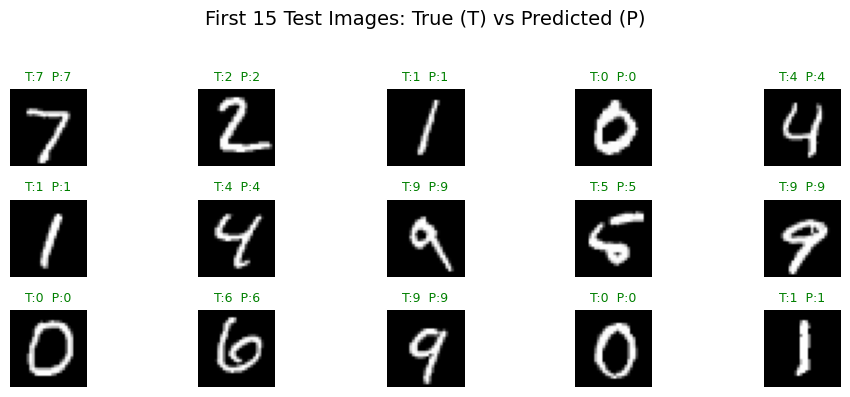

In [34]:
# ============================================================
# Evaluate and Visualize Model Performance
# ============================================================

# Evaluate tuned model on the test dataset
test_loss, test_acc = best_model.evaluate(X_test_flat, y_test, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f}")

# Generate predictions for the first 15 test samples
pred_probs = best_model.predict(X_test_flat[:15])
pred_labels = np.argmax(pred_probs, axis=1)

# Visualize true vs predicted labels
plt.figure(figsize=(10, 4))
for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap="gray")
    color = "green" if pred_labels[i] == y_test[i] else "red"
    plt.title(f"T:{y_test[i]}  P:{pred_labels[i]}", color=color, fontsize=9)
    plt.axis("off")

plt.suptitle("First 15 Test Images: True (T) vs Predicted (P)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
plt.show()

The training accuracy is .9641 and the test accuracy is .9524.

The tuned model is much more complex than the baseline model. The baseline model has 16 neurons in the hidden layer, while the tuned model has 128 neurons in the hidden layer. The tuned model found a better learning rate(.001) for the optimizer. There was a large performance improvement in the tuned model: the tuned model test accuracy was .9763 instead of the baseline .9524. These results indicate that the Keras tuner identified an ideal hyperparameter pattern to generalize for the images.

1. The output layer is the most significant architectural design difference. For the regression, the output layer has a singular neuron with a linear activation function. The classification output layer has multiple neurons and uses a softmax activation function. For the loss function, the regression aims to limit the error in the predicted continuous values and actual values, using Mean Squared Error. In the image classification, the goal is to assign the correct class to the images, using the sparse, categorical cross entropy loss function. For evaluation metric differences, the regression uses the Root Mean Squared Error and the R squared to evaluate the correctness of the predicted values vs actual values. In the classification, accuracy is quantified as the amount of correct classifications out of the total classifications.
2. For model structure, tabular data requires fully connected and the input neuron number is the same as the number of features. For images, the images must be flattened to vectors. For preprocessing requirements, both types of data need augmentation that includes scaling and normalization. With tabular data, features often need to be scaled. With images, pixel values must be scaled down. One-hot encoding is also applied to tabular data. In terms of learning complexity, there also significant differences. With tabular data, the models complexity is derived from combining features and their relative predictive accuracy. With images, the model complexity is derived from ranking features' importance.
3. The convergence challenge is most clear with the MLP regression. The convergence process was very slow. The Keras tuner improved this slow convergence. The TensorFlow showed the most overfitting, which was evident with the very high(-63.7829) R squared value. Optimal models are achieved via hyperparameter tuning using Randomized Search and Keras Tuner by not overfitting or underfitting. The early stopping prevents overfitting by stopping the model when it stops improving and begins including noise.